# Analytic Comparison
This notebook is a test to ensure the results from the numerical DLS model converge to the analytical results.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline
from fusiondls.Analytic_DLS import CfInt

In [2]:
from fusiondls import LfuncN, file_read, run_dls

eqb = file_read("eqb_store_lores.pkl")
profiles = eqb["V10"]["ou"]

In [3]:
# set switches
radios = {
    "ionisation": False,  # WIP - do not use. in development
    "upstreamGrid": True,  # SET TRUE if including domain above xpoint. if true, source of divertor heat flux comes from radial transport upstream, and Tu is at the midplane. If false, heat flux simply enters at the x point as qi, and Tu is located at the x point.
}

# set general run parameters
constants = {
    "gamma_sheath": 7,  # sheath transmittion coefficient for virtual target. Choice does not matter if Tt is low
    "Tt": 1,  # requested virtual target temp for calculating heat flux at detachment front. Aim for low (sub 1eV) Tt
    "qpllu0": 5e9,  # heat flux density at the x point
    "nu": 1e20,  # Upstream density (if constant)
    "nu0": 1e20,  # Upstream density (if constant)
    "cz0": 0.02,  # Impurity fraction (if constant)
    "Lfunc": LfuncN,  # impurity cooling function. More are available in AnalyticCoolingCurves.py
}

## DLS-Extended MMS test
- Higher powers make the radiation region thinner, and should mean that the answer converges on the DLS-Simple analytical solution.
- This is never going to be exact due to solver tolerances etc.


Solving...0.0000...7.5237...15.0474...Complete in 4.8 seconds


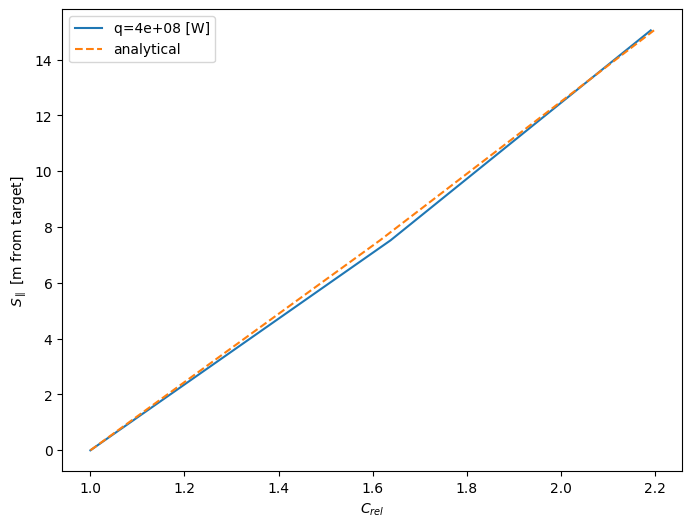

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
# Solve at these parallel positions
SparRange = np.linspace(0, profiles["S"][profiles["Xpoint"] - 1], 3)


endresults = []

# for heat_flux in np.linspace(1e8, 4e8, 4):
for heat_flux in [4e8]:
    constants["qpllu0"] = heat_flux

    results = run_dls(
        constants,
        radios,
        profiles,
        SparRange,
        control_variable="density",
        Ttol=1e-3,
        Ctol=1e-3,
        front_sheath=True,  # Analytical solution assumes sheath-like energy losses at the front
    )
    ax.plot(
        results["cvar"] / results["cvar"][0],
        results["Splot"],
        label=f"q={heat_flux:g} [W]",
    )
    endresults.append(results["cvar"][-1] / results["cvar"][0])


resultsAnalytical = [
    CfInt(
        profiles["S"],
        profiles["Btot"],
        profiles["Sx"],
        np.max(profiles["S"]),
        sh=s,
        kappa1=2500,
    )
    for s in SparRange
]

ax.plot(
    resultsAnalytical / resultsAnalytical[0],
    SparRange,
    label="analytical",
    linestyle="--",
)
ax.set_xlabel(r"$C_{rel}$")
ax.set_ylabel(r"$S_{\parallel}$ [m from target]")

ax.legend()
plt.show()

# Automatic test
- Compare the detachment window ($C_{rel}$ at the end of the scan) to the analytical result. It should be within 0.5%.

In [18]:
reference = resultsAnalytical[-1] / resultsAnalytical[0]
test = endresults[-1]

error = abs((test - reference) / reference)

np.testing.assert_array_less(error, 0.005, err_msg="Convergence to analytical solution failed")